## Stable Diffusion (Text to Image)

#### I. Imports 

In [3]:
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.utils import name_from_base
from sagemaker.predictor import Predictor
from sagemaker import get_execution_role
from sagemaker.model import Model
from sagemaker import script_uris
from sagemaker import image_uris
from sagemaker import model_uris
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import datetime
import logging
import boto3
import json

##### Setup logging 

In [4]:
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

##### Log versions of dependencies 

In [5]:
logger.info(f'[Using sagemaker version: {sagemaker.__version__}]')
logger.info(f'[Using boto3 version: {sagemaker.__version__}]')

[Using sagemaker version: 2.145.0]
[Using boto3 version: 2.145.0]


#### II. Setup essentials 

In [6]:
ROLE = get_execution_role()
REGION = boto3.Session().region_name
session = sagemaker.Session()
logger.info(f'Region: {REGION}')

Region: us-east-1


##### List all models from SageMaker JumpStart hub

In [7]:
models = list_jumpstart_models()
logger.info(f'Total number of models in SageMaker JumpStart hub = {len(models)}')

Total number of models in SageMaker JumpStart hub = 649


In [8]:
FILTER = 'task == txt2img'
txt2img_models = list_jumpstart_models(filter=FILTER)
txt2img_models

['huggingface-txt2img-22h-vintedois-diffusion-v0-1',
 'huggingface-txt2img-akikagura-mkgen-diffusion',
 'huggingface-txt2img-alxdfy-noggles-fastdb-4800',
 'huggingface-txt2img-alxdfy-noggles9000',
 'huggingface-txt2img-andite-anything-v4-0',
 'huggingface-txt2img-astraliteheart-pony-diffusion-v2',
 'huggingface-txt2img-avrik-abstract-anim-spritesheets',
 'huggingface-txt2img-aybeeceedee-knollingcase',
 'huggingface-txt2img-bingsu-my-k-anything-v3-0',
 'huggingface-txt2img-bingsu-my-korean-stable-diffusion-v1-5',
 'huggingface-txt2img-buntopsih-novgoranstefanovski',
 'huggingface-txt2img-claudfuen-photorealistic-fuen-v1',
 'huggingface-txt2img-coder119-vectorartz-diffusion',
 'huggingface-txt2img-conflictx-complex-lineart',
 'huggingface-txt2img-dallinmackay-cats-musical-diffusion',
 'huggingface-txt2img-dallinmackay-jwst-deep-space-diffusion',
 'huggingface-txt2img-dallinmackay-tron-legacy-diffusion',
 'huggingface-txt2img-dallinmackay-van-gogh-diffusion',
 'huggingface-txt2img-dgspitz

In [16]:
MODEL_ID = 'model-txt2img-stabilityai-stable-diffusion-v2-1-base'
MODEL_VERSION = '*'  # latest
SCOPE = 'inference'
INFERENCE_INSTANCE_TYPE = 'ml.g5.xlarge'# 'ml.p3.2xlarge'  # prefered

#### III. Retrieve inference artifacts 

In [10]:
inference_image_uri = image_uris.retrieve(region=REGION, 
                                          framework=None,
                                          model_id=MODEL_ID, 
                                          model_version=MODEL_VERSION, 
                                          image_scope=SCOPE, 
                                          instance_type=INFERENCE_INSTANCE_TYPE)
logger.info(f'Inference image URI: {inference_image_uri}')

Inference image URI: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04


In [11]:
inference_source_uri = script_uris.retrieve(model_id=MODEL_ID, 
                                            model_version=MODEL_VERSION, 
                                            script_scope=SCOPE)
logger.info(f'Inference source URI: {inference_source_uri}')

Inference source URI: s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz


In [12]:
inference_model_uri = model_uris.retrieve(model_id=MODEL_ID, 
                                          model_version=MODEL_VERSION, 
                                          model_scope=SCOPE)
logger.info(f'Inference model URI: {inference_model_uri}')

Inference model URI: s3://jumpstart-cache-prod-us-east-1/stabilityai-infer/prepack/v1.0.0/infer-prepack-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz


In [13]:
# To increase the maximum response size from the endpoint
env = {'MMS_MAX_RESPONSE_SIZE': '20000000'}

In [14]:
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
endpoint_name = f'js-sd-{current_time}'
logger.info(f'Endpoint name = {endpoint_name}')

Endpoint name = js-sd-20230420052603


In [15]:
model = Model(image_uri=inference_image_uri,
              source_dir=inference_source_uri,
              model_data=inference_model_uri,
              entry_point='inference.py',  
              role=ROLE,
              predictor_cls=Predictor,
              name=endpoint_name,
              env=env)

#### IV. Deploy Stable Diffusion model as a SageMaker endpoint

Takes around 11 to 14 mins

In [17]:
%%time

_ = model.deploy(initial_instance_count=1, 
                 instance_type=INFERENCE_INSTANCE_TYPE, 
                 predictor_cls=Predictor, 
                 endpoint_name=endpoint_name)

Created S3 bucket: sagemaker-us-east-1-186309751678
Creating model with name: js-sd-20230420052603
CreateModel request: {
    "ModelName": "js-sd-20230420052603",
    "ExecutionRoleArn": "arn:aws:iam::186309751678:role/cfn-sagemaker-immersion-day-SageMakerExecutionRole-E0E69O8C4H4",
    "PrimaryContainer": {
        "Image": "763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04",
        "Environment": {
            "MMS_MAX_RESPONSE_SIZE": "20000000",
            "SAGEMAKER_PROGRAM": "inference.py",
            "SAGEMAKER_SUBMIT_DIRECTORY": "/opt/ml/model/code",
            "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
            "SAGEMAKER_REGION": "us-east-1"
        },
        "ModelDataUrl": "s3://sagemaker-us-east-1-186309751678/js-sd-20230420052603/model.tar.gz"
    },
    "Tags": [
        {
            "Key": "aws-jumpstart-inference-model-uri",
            "Value": "s3://jumpstart-cache-prod-us-east-1/stabil

---------!CPU times: user 5min 30s, sys: 51.6 s, total: 6min 22s
Wall time: 11min 56s


#### V. Invoke the endpoint for inference 

In [18]:
ENDPOINT_NAME = 'js-sd-20230420052603'

In [19]:
client = boto3.client('sagemaker-runtime')

In [20]:
prompt = 'Cat in a space suit'

In [21]:
%%time

response = client.invoke_endpoint(EndpointName=endpoint_name, 
                                  Body=prompt, 
                                  ContentType='application/x-text')

CPU times: user 14.5 ms, sys: 282 µs, total: 14.8 ms
Wall time: 11.9 s


In [22]:
response_body = json.loads(response['Body'].read().decode())
generated_image = response_body['generated_image']

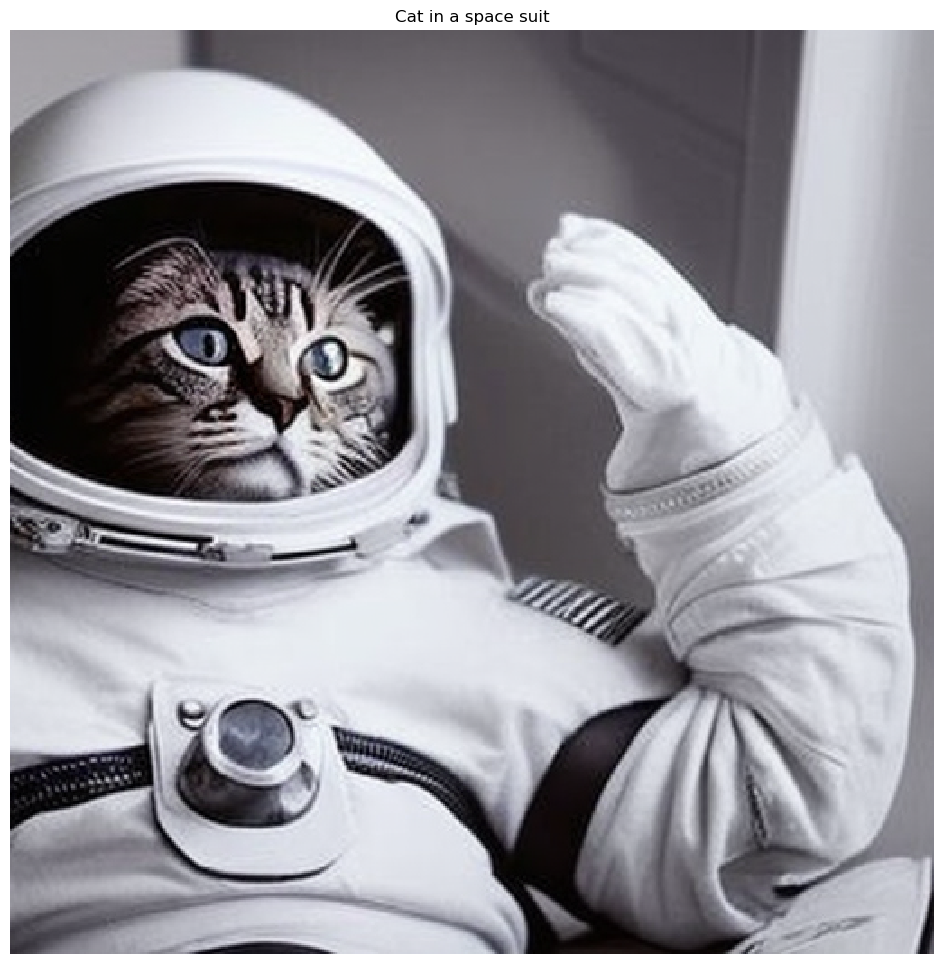

In [23]:
plt.figure(figsize=(12, 12))
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.title(prompt)
plt.show()

##### Invoke the model with generation parameters

In [24]:
prompt = """a cute magical flying cat, fantasy art drawn by disney concept artists, golden colour, high quality, highly detailed, elegant, sharp focus, concept art, character concepts, digital painting, mystery, adventure"""

* **`num_images_per_prompt`**: The num_images_per_prompt is the number of images that you want to generate for each prompt. It can be any positive integer value.
* **`num_inference_steps`**: The num_inference_steps is the number of steps that the image generator will take to create an image. It can be any positive integer value, but higher values may take longer time and consume more resources.
* **`guidance_scale`**: The guidance_scale is a parameter that controls how much the image generator will follow the prompt. It can be any positive decimal value, but higher values may result in more realistic images that match the prompt.

> **`num_inference_steps`** is the number of denoising steps that the image generator will take to create an image. Denoising steps are a process of removing noise from an image by applying a diffusion model that gradually refines the image quality. The more denoising steps you use, the higher quality image you can get, but it will also take longer time and consume more resources. The default value for num_inference_steps is `50`, which works well for most cases3. You can change this value according to your needs and preferences.

In [25]:
payload = {'prompt': prompt,
           'num_images_per_prompt': 1, 
           'num_inference_steps': 50, 
           'guidance_scale': 7.5
          }

In [26]:
payload = json.dumps(payload).encode('utf-8')

In [27]:
%%time

response = client.invoke_endpoint(EndpointName=endpoint_name, 
                                  Body=payload, 
                                  ContentType='application/x-text')

CPU times: user 3.87 ms, sys: 1.73 ms, total: 5.6 ms
Wall time: 7.05 s


In [28]:
response_body = json.loads(response['Body'].read().decode())
generated_image = response_body['generated_image']

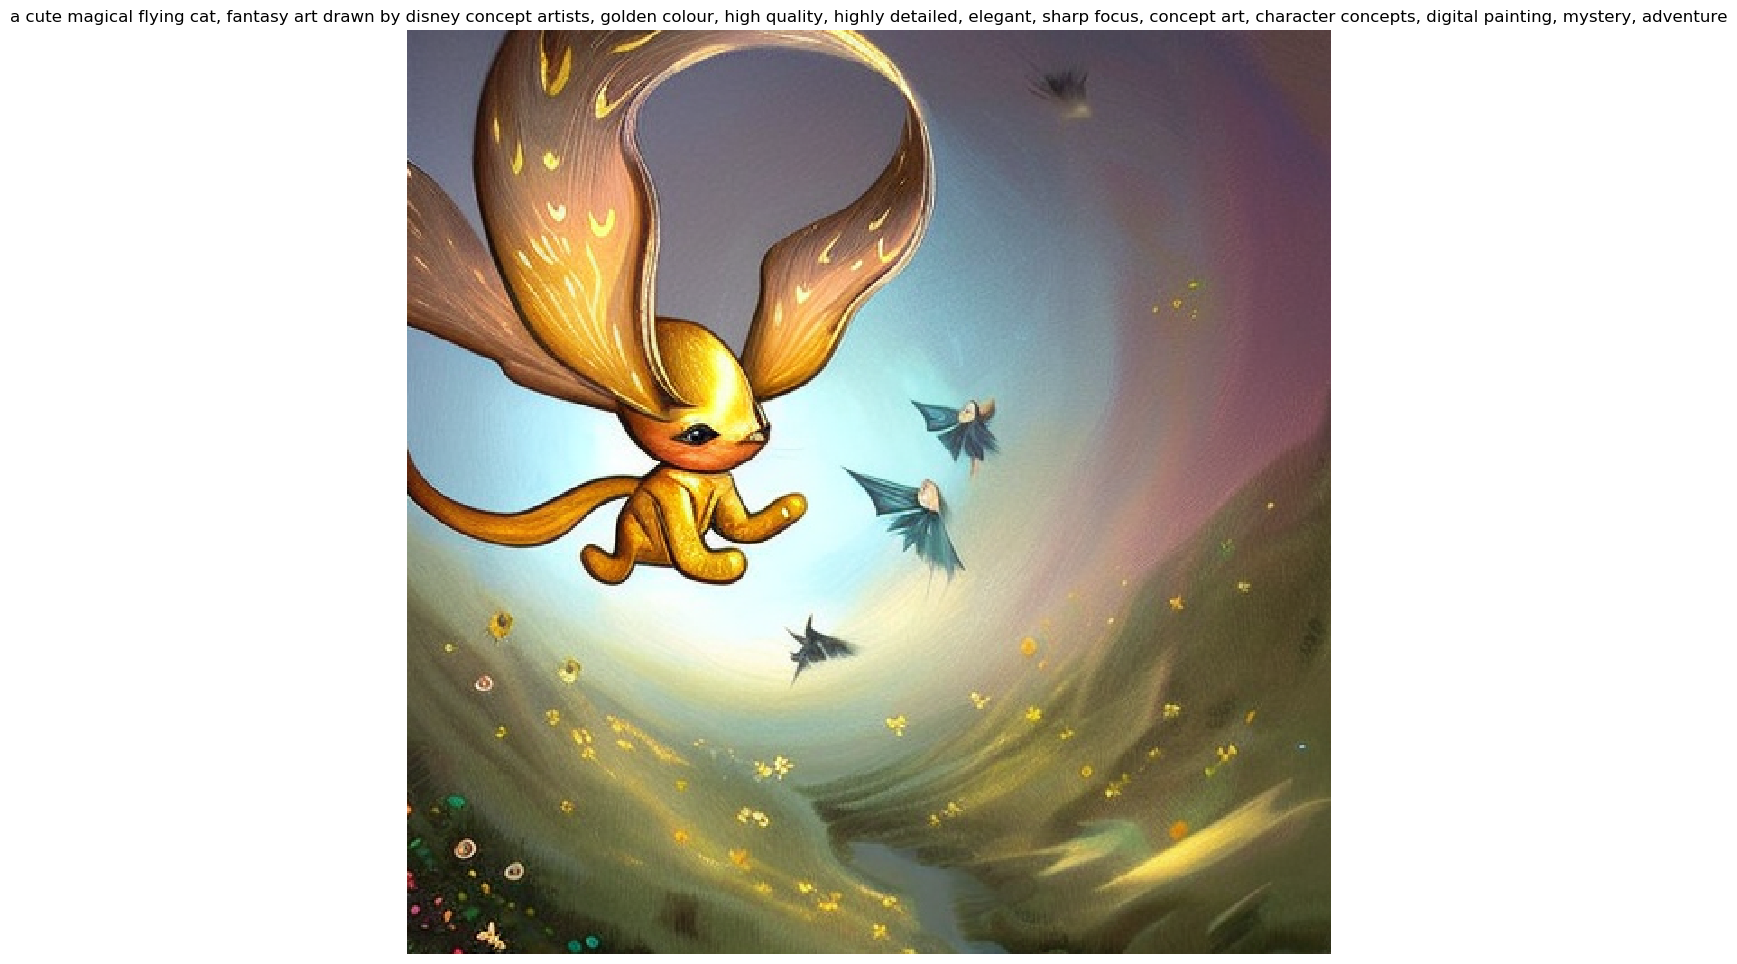

In [29]:
plt.figure(figsize=(12, 12))
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.title(prompt)
plt.show()